# Clustering trips

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

We read in the pickle file and take a look at our columns and values.

In [2]:
trips_df = pd.read_pickle('../00_data/trips_with_hourly_features.pkl')
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225280 entries, 210759 to 130228
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_type                   225280 non-null  int64  
 1   duration                    225280 non-null  float64
 2   distance                    225280 non-null  float64
 3   speed                       225280 non-null  float64
 4   sustenance_poi_start        225280 non-null  int64  
 5   public_transport_poi_start  225280 non-null  int64  
 6   education_poi_start         225280 non-null  int64  
 7   arts_and_culture_poi_start  225280 non-null  int64  
 8   sports_poi_start            225280 non-null  int64  
 9   sustenance_poi_end          225280 non-null  int64  
 10  public_transport_poi_end    225280 non-null  int64  
 11  education_poi_end           225280 non-null  int64  
 12  arts_and_culture_poi_end    225280 non-null  int64  
 13  sports_po

In [3]:
trips_df.head(2)

,user_type,duration,distance,speed,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,...,arts_and_culture_poi_end,sports_poi_end,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end
210759,0,80.0,0.000000,0.000000,1,1,0,0,0,1,...,0,0,15.6,0.0,1,1,1,1,1,2
55231,0,4.0,0.156355,2.345331,1,1,1,1,1,1,...,1,1,15.6,0.0,1,1,1,1,1,1


For a 2D Visualization we plot some features with other ones to eventually see first clusters with our eyes. Because
categorical values like _weekday_, _month_, etc. are already distinguished as a group we will leave them out.
We leave _hour_start_ and _hour_end_ in the dataset because these are interesting values and their 24 categories are easier to differentiate in clusters than features with fewer categories.

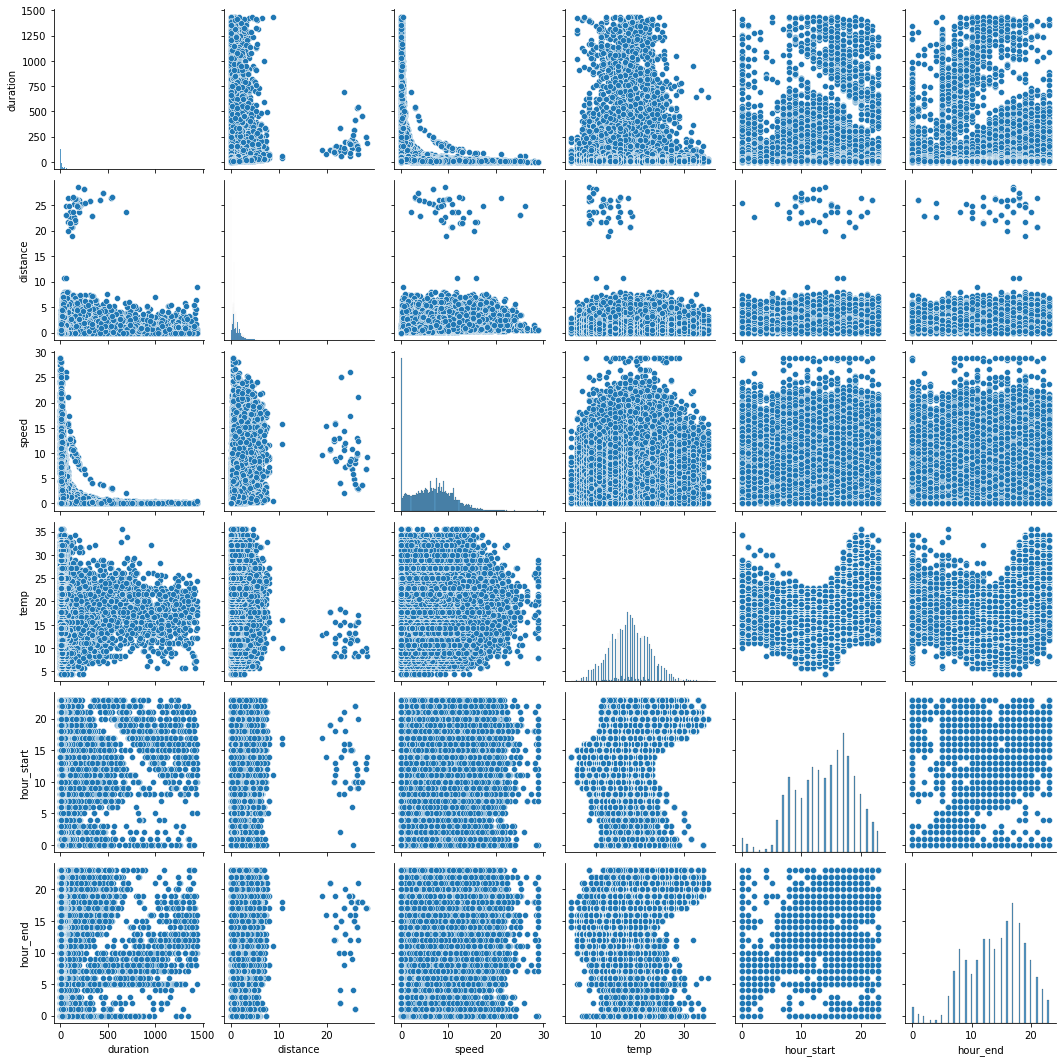

In [4]:
sns.pairplot(data=trips_df.drop(columns=[
    "day_of_week", "month", "is_weekday", "is_holiday",
    "user_type", "precip",
    "sustenance_poi_start", "public_transport_poi_start",
    "education_poi_start", "arts_and_culture_poi_start",
    "sports_poi_start", "sustenance_poi_end",
    "public_transport_poi_end", "education_poi_end",
    "arts_and_culture_poi_end", "sports_poi_end"]))
# plot not discrete only

Looking at all plots we can recognize some groups that are distinguished:
 - Especially in the feature _distance_ there is a clear cut between long and short trips.
 - In _duration_ to _speed_ we see a little cut between points in the middle and near the axes.
 - Between _duration_ and both _hour_start_ and _hour_end_ there seems to be a linear cut through the data.
 - Comparing _speed_ to other features we see some very fast bike riders in contrast to slower ones.

Let us scale the features so the distances we will compute are in the same range.

In [5]:
X = trips_df
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(2)

,user_type,duration,distance,speed,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,...,arts_and_culture_poi_end,sports_poi_end,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end
210759,-1.412256,0.869304,-1.050413,-1.430151,0.09583,0.229941,-1.351885,-1.610345,-1.272047,0.095901,...,-1.651464,-1.265625,-0.453914,-0.148284,-2.66328,-0.934281,-1.754494,0.534645,4.778769,-2.447265
55231,-1.412256,-0.251611,-0.893922,-0.891799,0.09583,0.229941,0.739708,0.620985,0.786134,0.095901,...,0.605523,0.790124,-0.453914,-0.148284,-2.66328,-0.934281,-1.754494,0.534645,4.778769,-2.649789


## PCA Dimensionality Reduction

Because we have 21 features we try to reduce the dimensionality with a principal component analysis. First we try it with 7 components (3 features per component).

In [6]:
pca = PCA(n_components=7)
trips_scaled_pca = pca.fit_transform(X_scaled_df)
print(sum(pca.explained_variance_ratio_))

0.5177053270886679


Because the explained variance ratio is only about 52% we try reducing the dimensionality to 10 PCA components (~2 features per component).

In [7]:
pca = PCA(n_components=10)
trips_scaled_pca = pca.fit_transform(X_scaled_df)
print(sum(pca.explained_variance_ratio_))

0.6614267087491974


Because 66% is still not sufficient for a feature reduction we will run the clustering without reducing the feature dimensionality.

## Algorithm 1: K-means++

Now we will run the clustering algorithm K-means++ on this data to answer three main questions:
1. Which clusters are found by the algorithm?
2. Are those clusters useful and informative in terms of our business values?
3. Can our cluster assumptions made above be found in the clusters by the algorithm?

We can use the KMeans() Model because scikit learn automatically uses K-means++
when not indicating that you want to have the original K-means with randomly selected centers in the beginning.

In [8]:
# defining the maximum quantity of centers
k_max = 20

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = KMeans(n_clusters=k + 1, )
    model.fit(X_scaled)
    clusters.append(k + 1)
    losses.append(model.inertia_)

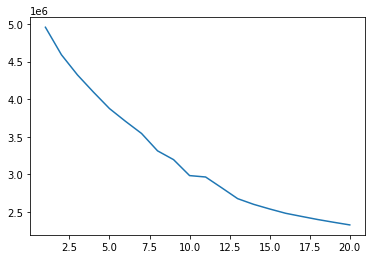

In [9]:
# plot losses
plt.plot(clusters, losses)
plt.show()

(0.0, 12.0)

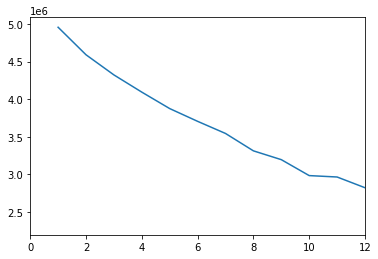

In [10]:
# plot losses more detailed
plt.plot(clusters, losses)
plt.xlim([0, 12])

The loss of course decreases with the quantity of clusters. Because we already have many features we set K=10 as there is a "hard edge" in the loss graph. This seems like a reasonable value for our cluster quantity so we will run the model with 10 clusters again and take a closer look. Furthermore we add a random state to our model so it can be recreated with the same cluster-label-numbers.

In [11]:
# run again with k=10
ten_means = KMeans(n_clusters=10, random_state=4711)
ten_means.fit(X_scaled)
ten_means.predict(X_scaled)

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [12]:
# create dataframe with clusters, their size and the means of the features
clusters = ten_means.cluster_centers_
clusters = scaler.inverse_transform(clusters)
clusters_df = pd.DataFrame(clusters, columns=X.columns)
clusters_rounded_df = clusters_df.round(2)
clusters_rounded_df["size"] = X_scaled_df.groupby(ten_means.labels_).size()
clusters_rounded_df.head(10)

,user_type,duration,distance,speed,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,...,sports_poi_end,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end,size
0,0.98,20.35,0.66,4.51,1.00,1.00,0.61,0.94,0.90,1.0,...,0.88,14.80,0.00,12.95,2.15,5.41,1.00,0.00,13.07,44417
1,0.77,46.73,0.97,4.34,1.00,0.70,0.79,0.03,0.25,1.0,...,0.29,17.80,0.00,15.06,3.08,7.14,0.74,-0.00,15.16,25099
2,0.88,26.19,1.05,5.09,1.00,1.00,0.62,0.80,0.76,1.0,...,0.76,17.88,0.00,14.82,5.50,6.96,0.00,-0.00,15.01,35924
3,0.86,24.23,1.03,5.80,1.00,0.96,0.64,0.70,0.64,1.0,...,0.64,17.24,0.00,14.27,1.91,7.16,0.82,1.00,14.46,8754
4,0.80,24.72,1.28,6.24,1.00,0.78,0.67,0.59,0.60,1.0,...,0.55,18.01,0.00,13.81,2.96,7.12,0.74,0.01,13.97,10821
5,0.92,20.57,0.94,5.87,1.00,0.96,0.66,0.76,0.69,1.0,...,0.68,13.89,0.94,14.87,2.43,4.79,0.82,0.09,15.11,4565
6,1.00,10.77,1.34,8.99,1.00,0.99,0.56,0.72,0.33,1.0,...,0.45,17.02,0.00,7.97,2.13,7.43,0.96,-0.00,8.08,39380
7,0.99,12.42,1.15,7.37,1.00,1.00,0.69,0.86,0.68,1.0,...,0.59,20.62,0.00,18.01,2.00,7.67,1.00,0.00,18.18,52433
8,0.89,19.94,1.26,6.37,0.89,0.91,0.71,0.73,0.68,-0.0,...,0.00,17.96,0.02,13.14,2.76,7.80,0.79,0.04,13.27,2053
9,0.93,19.17,1.41,7.21,-0.00,0.78,0.51,0.31,-0.00,1.0,...,0.77,17.87,0.02,14.54,2.72,7.84,0.81,0.05,14.69,1834


### 1. Which clusters are found by the algorithm?

Now we will analyse each cluster to label it.

In [13]:
# map cluster to data
X["cluster"] = ten_means.labels_

In [14]:
# function for plotting comparing clusters in different features
def show_cluster_values(columns):
    fig, axs = plt.subplots(int(len(columns)/2),2)
    fig.set_size_inches(10,10)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(x=X["cluster"], y=X[col], data=X, palette="magma",  ax=axs[plots_row][plots_col])
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1

First we take a look at th points of interest.

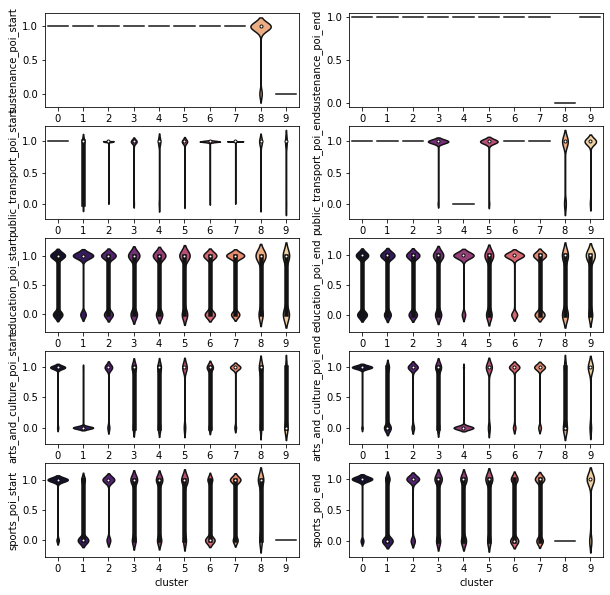

In [15]:
show_cluster_values([
    "sustenance_poi_start", "sustenance_poi_end",
    "public_transport_poi_start","public_transport_poi_end",
    "education_poi_start", "education_poi_end",
    "arts_and_culture_poi_start", "arts_and_culture_poi_end",
    "sports_poi_start", "sports_poi_end"])

On the left side are the POIs near the starting stations and on the left near the destinations. This is the analysis:
- sustenance: In cluster 9 there are no sustenance POIs near the start and none near the end in cluster 8.
- public transport: Cluster 0 are trips that always start near public transport and besides cluster 4 every trip ends near public transport.
- education: The POIs for education are distributed equally.
- arts and culture: For this POIs cluster 2 has no arts in its starting points whereas cluster 4 none at its endpoints has.
- sports: Cluster 9 has no sports POIs in the beginning and cluster 8 in the end.

All in all the results for POIs are hard to interpret because we do not have clusters where all trips to a specific POI are in one cluster but rather all trips that do not have that POI are in one. We can see that most trips drive to public transport and sustenance.

Now we want to analyse the features that are time related:

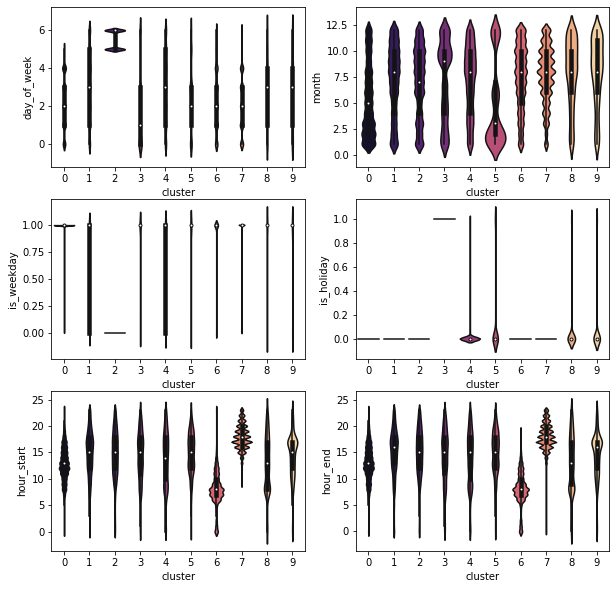

In [16]:
show_cluster_values(["day_of_week", "month", "is_weekday", "is_holiday", "hour_start", "hour_end"])

- day_of_week and is_weekday: Cluster 2 describes trips on the weekend.
- month: Cluster 5 are trips in winter and clusters 6 and 7 are trips mostly in the summer
- is_holiday: Cluster 3 describes only trips that are done on a holiday.
- hour_start and hour_end: Cluster 0 are trips that start and end around noon. 6 are morning and 7 evening trips.

Now we will take a look at the rest of the features:

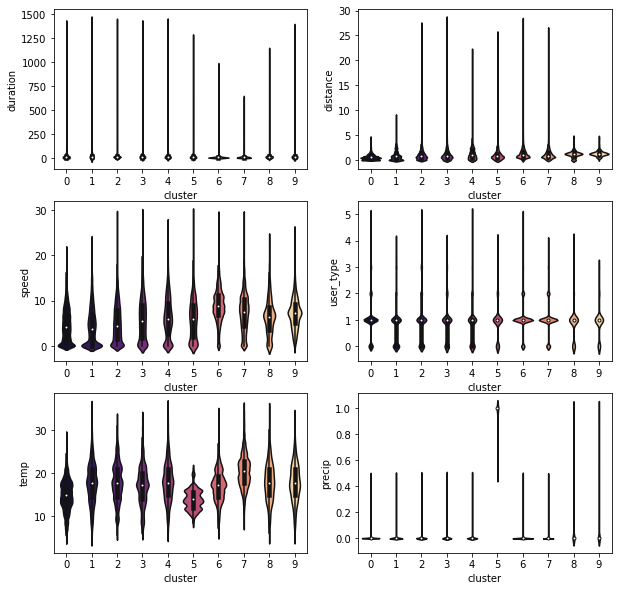

In [17]:
show_cluster_values(["duration", "distance", "speed", "user_type", "temp", "precip"])

- duration, distance, speed: Clusters 6 and 7 have shorter durations and are slightly faster than other clusters. The distance is cut in short (0,1,8,9) and long trips (2-7) but most trips in all clusters have a rather short distance.
- user_type: equally distributed but user type 5 only appears in 0,2,4,6 and user type 4 does not appear in 9.
- weather: Cluster 5 are trips where it rains and temperatures are lower. Cluster 7 describes warmer temperatures and cluster 0 colder ones.

If we sum up our findings we can label the clusters as such:
- Cluster 0: only public transport start, around noon, short distance, cold - **continue noon**
- Cluster 1: short distance - **short**
- Cluster 2: no art POIs at start point, only weekend, long distance - **weekend**
- Cluster 3: only holiday, long distance - **holiday**
- Cluster 4: no public transport or arts destination, long distance- **no continue**
- Cluster 5: winter, low temperature, rain, long distance - **winter**
- Cluster 6: summer, morning, short duration, fast, long distance - **summer morning**
- Cluster 7: summer, evening, warm, short duration, fast, long distance - **summer evening**
- Cluster 8: no sustenance or sports POIs at end, short distance - **no sustenance or sport destination**
- Cluster 9: no sustenance or sports POIs at start, short distance - **no sustenance or sport start**

In [18]:
labels = [ "continue noon", "short trip", "weekend", "holiday", "no continue", "winter", "summer morning",
           "summer evening", "no sustenance or sport destination", "no sustenance or sport destination"]

X["label"] = X["cluster"].apply(lambda x: labels[x])
X.head()

,user_type,duration,distance,speed,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,...,temp,precip,hour_start,day_of_week,month,is_weekday,is_holiday,hour_end,cluster,label
210759,0,80.0,0.000000,0.000000,1,1,0,0,0,1,...,15.6,0.0,1,1,1,1,1,2,3,holiday
55231,0,4.0,0.156355,2.345331,1,1,1,1,1,1,...,15.6,0.0,1,1,1,1,1,1,3,holiday
210760,0,78.0,0.000000,0.000000,1,1,0,0,0,1,...,15.6,0.0,1,1,1,1,1,2,3,holiday
150266,0,37.0,3.030349,4.914079,1,1,0,1,1,1,...,15.6,0.0,1,1,1,1,1,2,3,holiday
150267,0,36.0,3.030349,5.050581,1,1,0,1,1,1,...,15.6,0.0,1,1,1,1,1,2,3,holiday


### 2. Are those clusters useful and informative in terms of our business values?

Some of the clusters are useful for information about the bikesharing business. We can map new trips into these clusters and predict similarities. We could also create new pricing models by these clusters. For example a special summer evening package for the users that drive in the _summer evening_ cluster or a public transport ticket which only accepts stations near public transport for people who often continue their trip.

In general we can get many information out of our clusters but for an exact analysis the clustering should rather focus on some subgroup of features. For example a clustering with only points of interests or only time and weather related features. By that the clusters do not get messy and a better overview can help finding the most important information.

### 3. Can our cluster assumptions made above be found in the clusters by the algorithm?

For this question we plot our assumption above in 2D again:

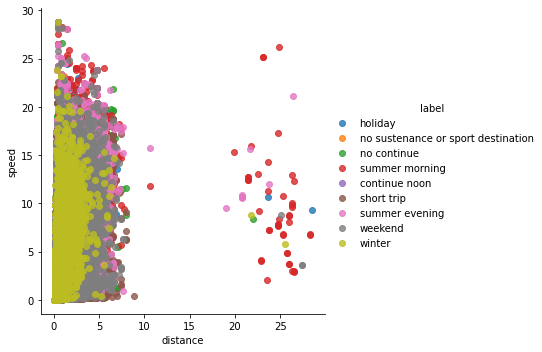

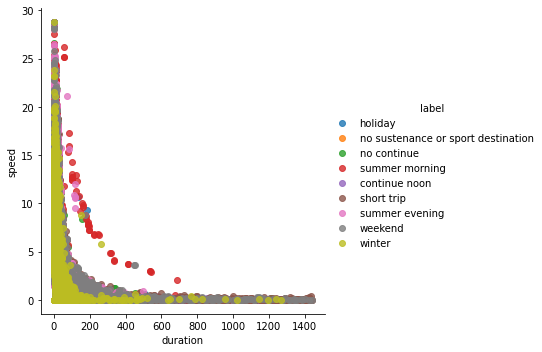

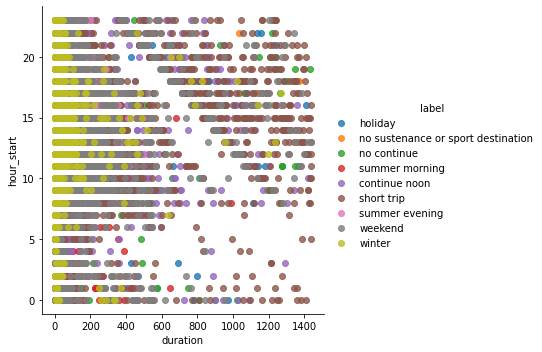

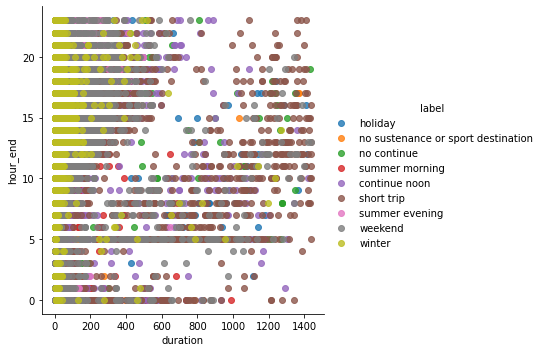

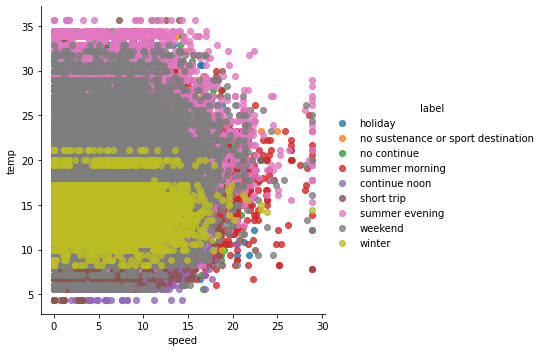

In [19]:
sns.lmplot(x="distance", y="speed", data=X, fit_reg=False, hue="label")
sns.lmplot(x="duration", y="speed", data=X, fit_reg=False, hue="label")
sns.lmplot(x="duration", y="hour_start", data=X, fit_reg=False, hue="label")
sns.lmplot(x="duration", y="hour_end", data=X, fit_reg=False, hue="label")
sns.lmplot(x="speed", y="temp", data=X, fit_reg=False, hue="label")

 - distance -> all: Longer trips are mostly summer and holiday trips whereas winter trips are short. We can see different clusters but there are no only long trip clusters as we assumed in the beginning.
 - duration -> speed: As with the distance in the plot above the smaller group of points here is mostly summer clusters. We can see different clusters in different groups here too.
 - duration -> hour_start and hour_end: Here the data points are very mixed and the linear cut does not distinguish clusters.
 - speed -> temp: Here we can see a cut between different clusters from inner to outer but not between very fast riders and slower ones.